Figures 4,5,6,7 were produced with this code. 

# Case 2 - Quasi Synthetic Normal Mode Application

The Problem class in the SOLA_DLI file contains all the tools for solving a SOLA problem within the "property bounds perspective". We start as usual by importing the needed packages

In [23]:
from sola.main_classes import domains
from sola.main_classes import spaces
from sola.main_classes import functions
from sola.main_classes import mappings
from sola.main_classes.SOLA_DLI import Problem
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib

# Set global parameters for matplotlib
plt.rcParams.update({'font.size': 15})  # Set default font size
plt.rcParams['axes.linewidth'] = 1.5  # Set the thickness of the axes lines
# Create color Palette
colors = sns.color_palette('YlGnBu', n_colors=100)


Before even attempting to SOLVE a SOLA problem we must first define the mappings and spaces that we will work in. We will build these mathematical components one by one starting with the model space. 

The lines of codes in the "Edit regions" can be modified to explore variations of the given default SOLA problem.

In [24]:
####################
# Create model space
####################
# Edit region -------------
physical_parameters = ['m_1', 'm_2', 'm_3']
physical_parameters_symbols = {'m_1': '$m^1$', 'm_2': '$m^2$', 'm_3': '$m^3$'}
# Edit region -------------

no_of_params = len(physical_parameters)
domain = domains.HyperParalelipiped(bounds=[[0, 1]])
constituent_models_spaces = [spaces.PCb(domain=domain) for _ in physical_parameters]
# Create a dictionary with physical parameters as keys
models_dict = {param: model_space for param, model_space in zip(physical_parameters, constituent_models_spaces)}
# Create the model space from the constituent model spaces
M = spaces.DirectSumSpace(tuple(constituent_models_spaces))

Then the data space. here we only specify how many data points we want to have. The more we have, the more costly it will be, but the error bounds will be smaller.

In [25]:
###################
# Create Data space
###################
# Edit region -------------
how_many_data = 150
# Edit region -------------

D = spaces.RN(dimension=how_many_data)

The the model-data mapping.

In [26]:
###########################
# Create model-data mapping
###########################
# Edit region ------------------------
no_sensitivity_regions = {'m_1': None,
                          'm_2': [[0.5, 0.75]],
                          'm_3': None}
# Edit region ------------------------

# Make them into functions via interpolation
sensitivity_dict = {}
for i, param in enumerate(physical_parameters):
    sensitivity_dict[param] = []
    for index in range(how_many_data):
        # These parameters have a region of insensitivity
        sensitivity_dict[param].append(functions.NormalModes_1D(domain=domain, order=3, spread=0.05,
                                                    max_freq=10, seed=index + i*how_many_data,
                                                    no_sensitivity_regions=no_sensitivity_regions[param]))
# Each constituent mapping is an integral mapping
constituent_mappings = [mappings.IntegralMapping(domain=models_dict[param], codomain=D,
                                        kernels=sensitivity_dict[param]) for param in physical_parameters]
mappings_dict = {param: mapping for param, mapping in zip(physical_parameters, constituent_mappings)}
G = mappings.DirectSumMapping(domain=M, codomain=D, mappings=tuple(constituent_mappings))

Now we plot the Sensitivity kernels

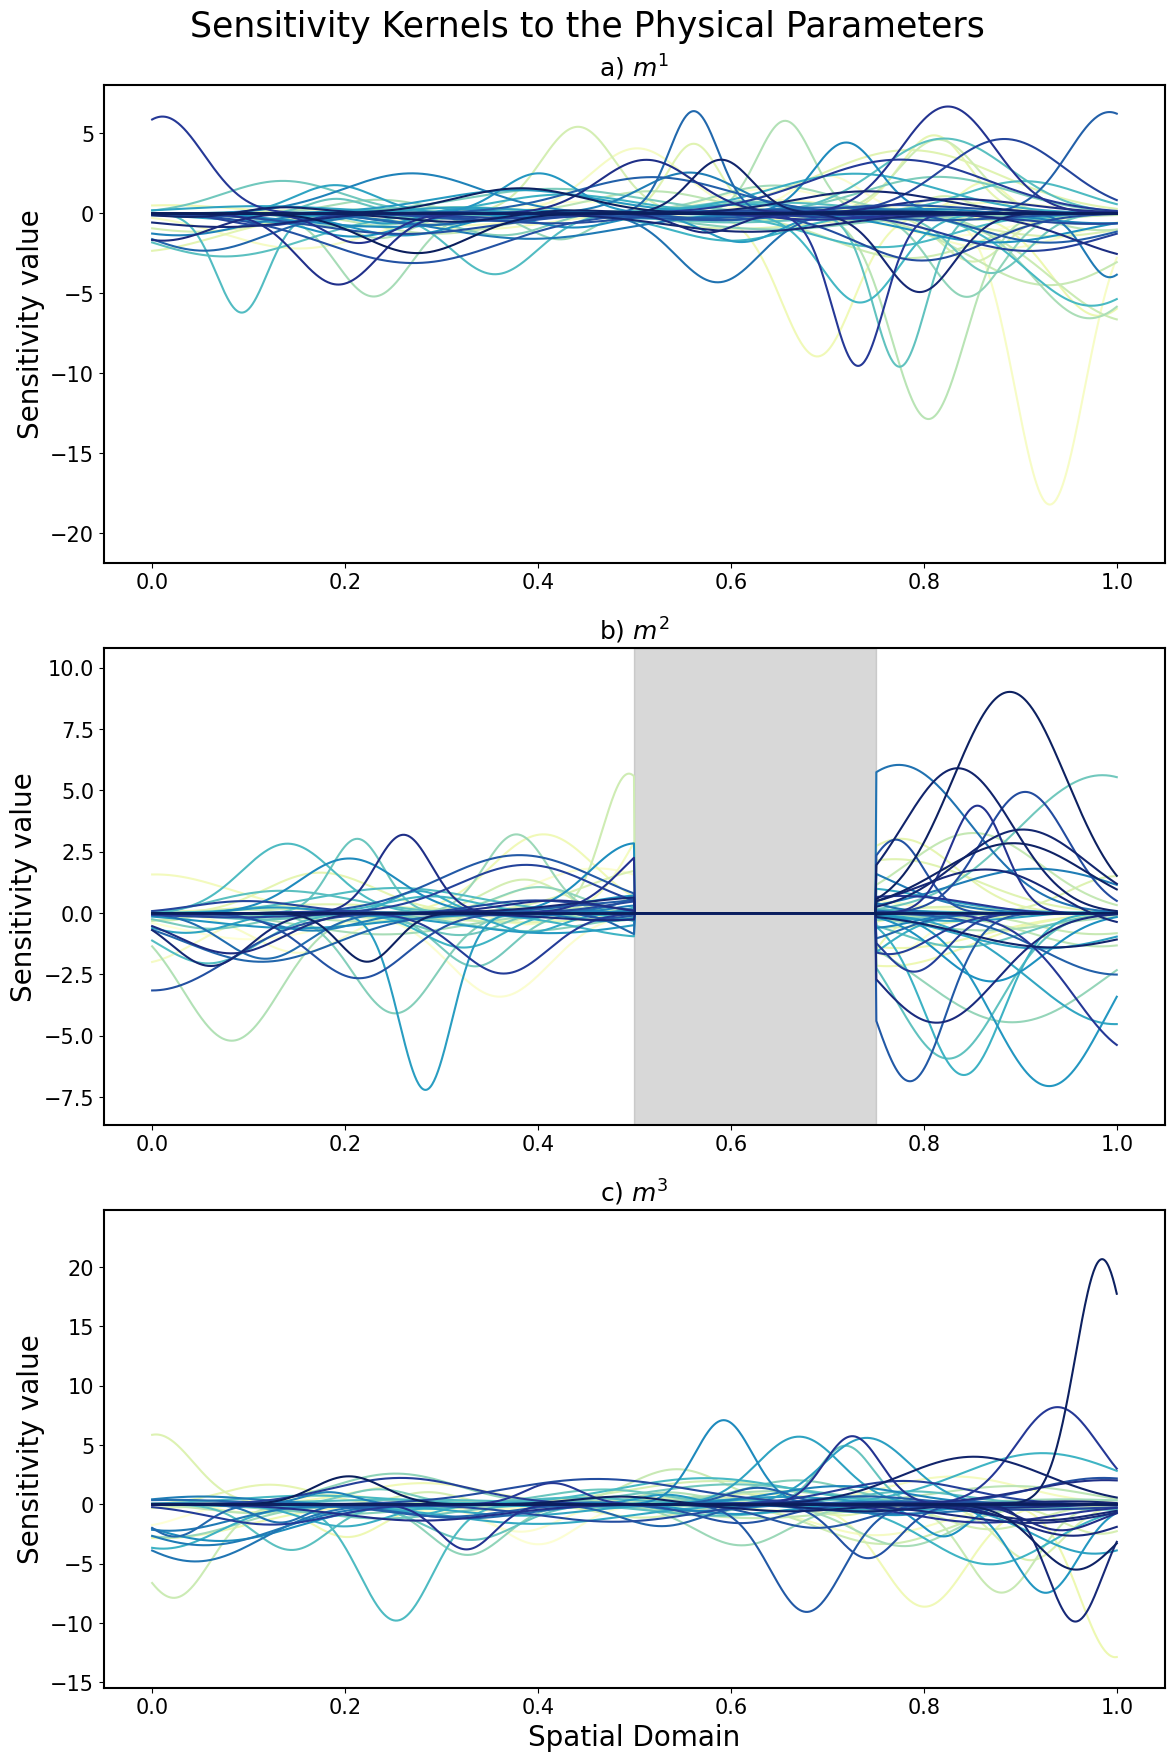

In [27]:
%matplotlib inline
fig, axes = plt.subplots(len(physical_parameters), 1, figsize=(12, 6*len(physical_parameters)))
labels = ['a) ', 'b) ', 'c) '] # for plotting the labels
for i, param in enumerate(physical_parameters):
    # Initialize y_min and y_max with extreme values to be updated dynamically
    y_min = float('inf')
    y_max = float('-inf')

    for j, kernel in enumerate(sensitivity_dict[param]):
        y_values = kernel.evaluate(domain.mesh)  # Extract y-values from the kernel data

        # Update y_min and y_max based on current kernel's data
        y_min = min(y_min, np.min(y_values))
        y_max = max(y_max, np.max(y_values))

        axes[i].plot(domain.mesh, y_values, color=colors[int(100*j/how_many_data)])
    y_min *= 1.2
    y_max *= 1.2
    axes[i].set_title(labels[i] + physical_parameters_symbols[param],)
    axes[i].tick_params(axis='both', which='major', labelsize=15)
    axes[i].set_ylim([y_min, y_max])
    axes[i].set_ylabel('Sensitivity value', fontsize=20)

    if no_sensitivity_regions[param] is not None:
        for no_sensitivity_region in no_sensitivity_regions[param]:
            axes[i].fill_betweenx([y_min, y_max], no_sensitivity_region[0], no_sensitivity_region[1],
                                  color='gray', alpha=0.3, label='No Sensitivity Region')

# Adjust fontsize for ticks
axes[i].set_xlabel('Spatial Domain', fontsize=20)
plt.suptitle('Sensitivity Kernels to the Physical Parameters', fontsize=25)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.tight_layout()
plt.savefig('Kernels_for_paper.pdf', bbox_inches='tight', dpi=300)
plt.show()

Now we create the property mapping. The physical properties we are not interested in must have a Null target function, while the physical property of interest will have a target function dictated by what property we want to extract from it. For example:
- Local uniform average: functions.Boxcar_1D
- Gaussian average: functions.Gaussian_1D
- Gaussian derivative: functions.Dgaussian_1D
- Bump average: functions.Bump_1D
- Bump derivative: functions.Dbump_1D

In [28]:
###################################
# Create property mapping and space
###################################
# Edit region -------------
# First we choose what kinf of property we want
chosen_target_type = functions.Boxcar_1D
# Then we say on which parameter we want to apply it
target_types = {'m_1': functions.Null_1D,
                'm_2': chosen_target_type,
                'm_3': functions.Null_1D}
# Now we go into the details of the chosen target type
how_many_targets = 100
width = 0.2 # same units as domain (km here)
# Enquiry points are the centers of the target kernels
enquiry_points = np.linspace(domain.bounds[0][0],
                             domain.bounds[0][1],
                             how_many_targets)
# Edit region -------------

P = spaces.RN(dimension=how_many_targets)
targets_dict = {}
for param, target_type in target_types.items():
    targets_dict[param] = []
    for i in range(how_many_targets):
        if target_type == chosen_target_type:
            targets_dict[param].append(target_type(domain=domain,
                                                   center=enquiry_points[i],
                                                   width=width))
        else:
            targets_dict[param].append(target_type(domain=domain))
constituent_mappings = [mappings.IntegralMapping(domain=models_dict[param], codomain=P,
                                        kernels=targets_dict[param]) for param in physical_parameters]
T = mappings.DirectSumMapping(domain=M, codomain=P, mappings=tuple(constituent_mappings))

Now we create a fake true model.

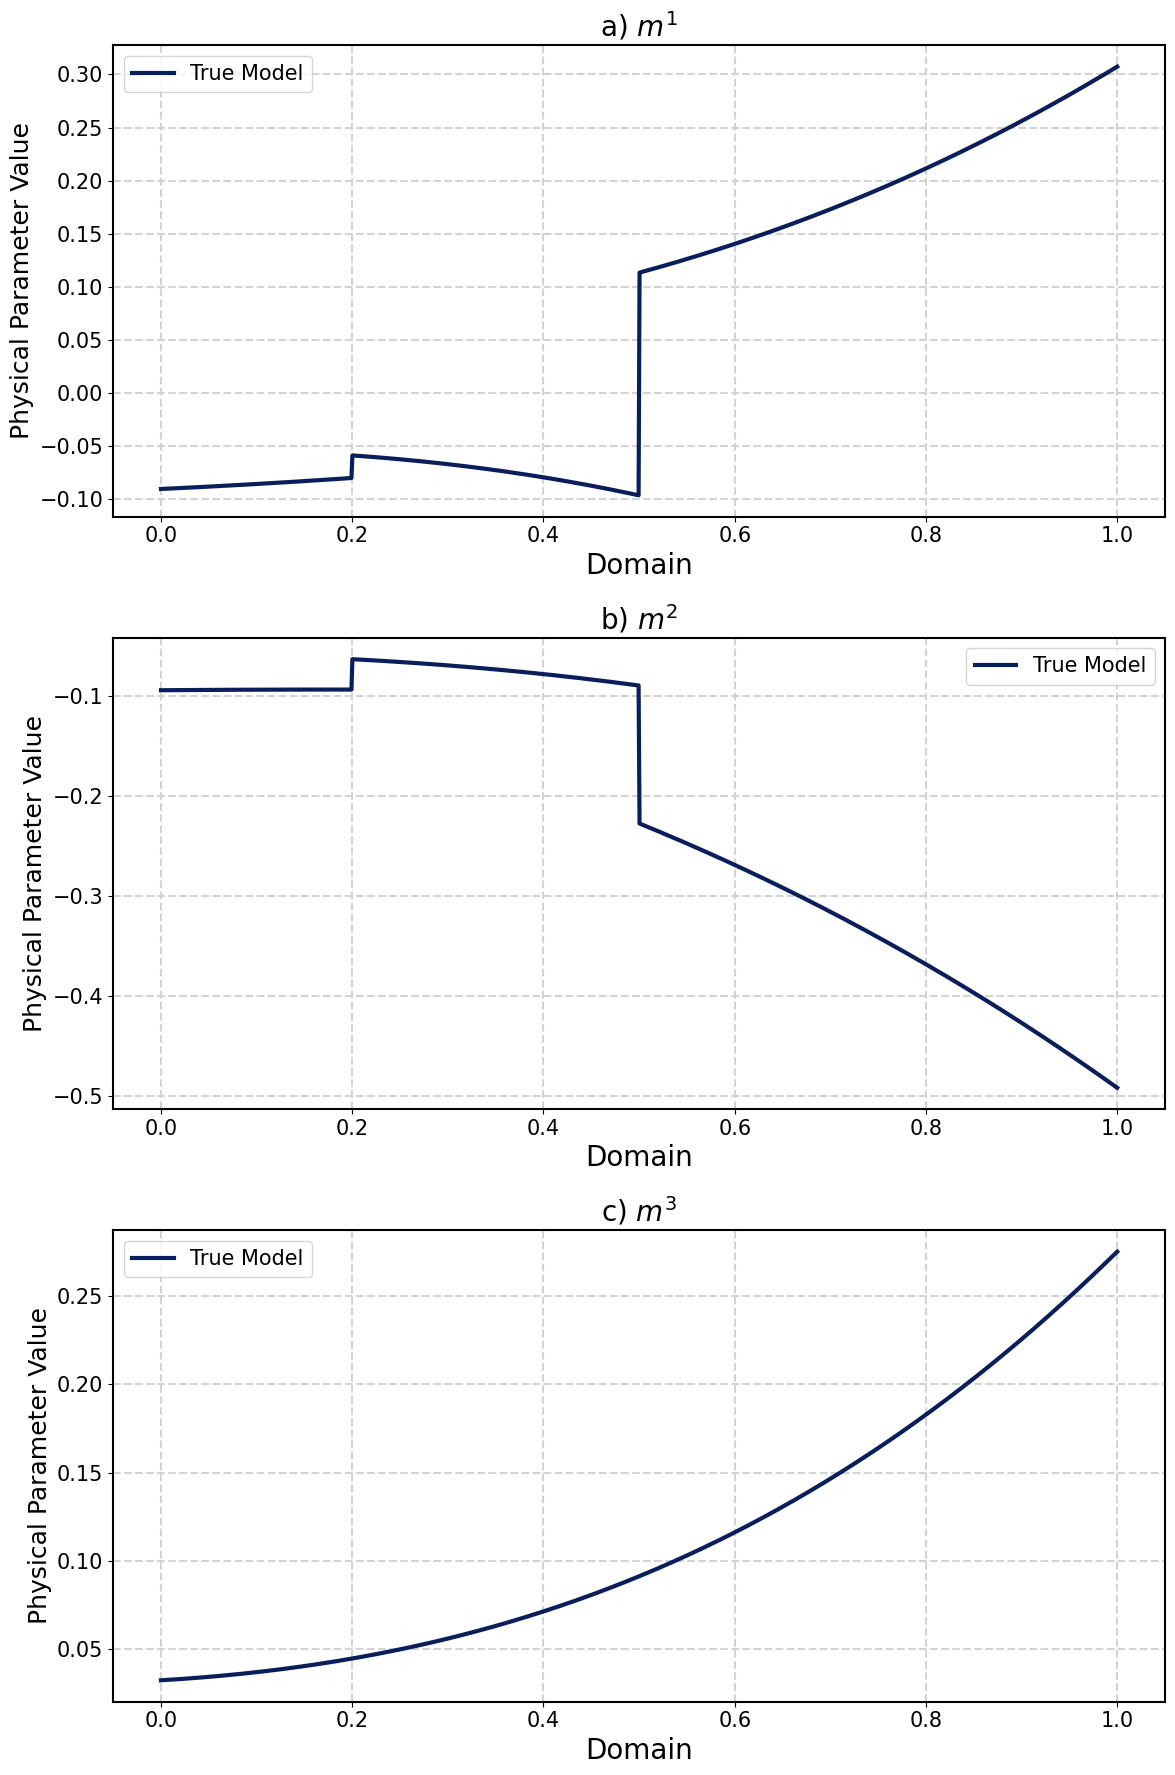

In [29]:
%matplotlib inline
#################################
# Create fake true model and data
#################################
# Edit region -------------
# Each row in the list of arguments is a tuple with the following structure:
# (seed, is it continuous?, locations of discontinuities)
# If you flag it as not continuous, and don't give the discontinuities, it will
# put them randomly
true_model = M.random_member(args_list=[(10, False, [0.2, 0.5]),
                                        (2, False, [0.2, 0.5]),
                                        (3, True)])
# Edit region -------------

# We generate the data
data = G.map(true_model)

# And now we plot
fig, axes = plt.subplots(len(physical_parameters), 1, figsize=(12,6*len(physical_parameters)))
for i, (submodel, physical_parameter) in enumerate(zip(true_model, physical_parameters)):
    axes[i].plot(domain.mesh, submodel.evaluate(domain.mesh),
            label='True Model', color=colors[99], linewidth=3)
    axes[i].set_title(labels[i] + physical_parameters_symbols[physical_parameter], fontsize=20)
    axes[i].set_ylabel('Physical Parameter Value', fontsize=18)
    axes[i].tick_params(axis='both', which='major', labelsize=15)
    axes[i].legend(fontsize=15)
    axes[i].grid(True, linestyle='--', linewidth=1.5, color='lightgray')  # Add gridlines
axes[-1].set_xlabel('Spatial Domain', fontsize=20)
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.savefig('truth.png', dpi=300, bbox_inches='tight')  # Save figure
plt.show()

Now we create a norm bound (this is the last step in setting up the SOLA-DLI problem). The way we create the norm bound here is as follows:
1. We partition the spatial domain in some intervals
2. We evaluate the absolute values of the true model at the left ends of these intervals and multiply by 1.5
3. We create a piece-wise function based on the intervals and the values calculated in 2. This will be the upper bound function

If you decide to play around with this section, make sure to inspect the upper bounds to make sure that they are indeed upper bounds (the true model does not lie below these upper bounds anywhere). Also, note that upper bounds for SOLA-DLI must be upper bounds for the absolute value of the true model, not for the model itsel. In other words, if the true model has a value of -2 at some point, then the upper bound cannot be -1 or 0, it must be something bigger than 2.

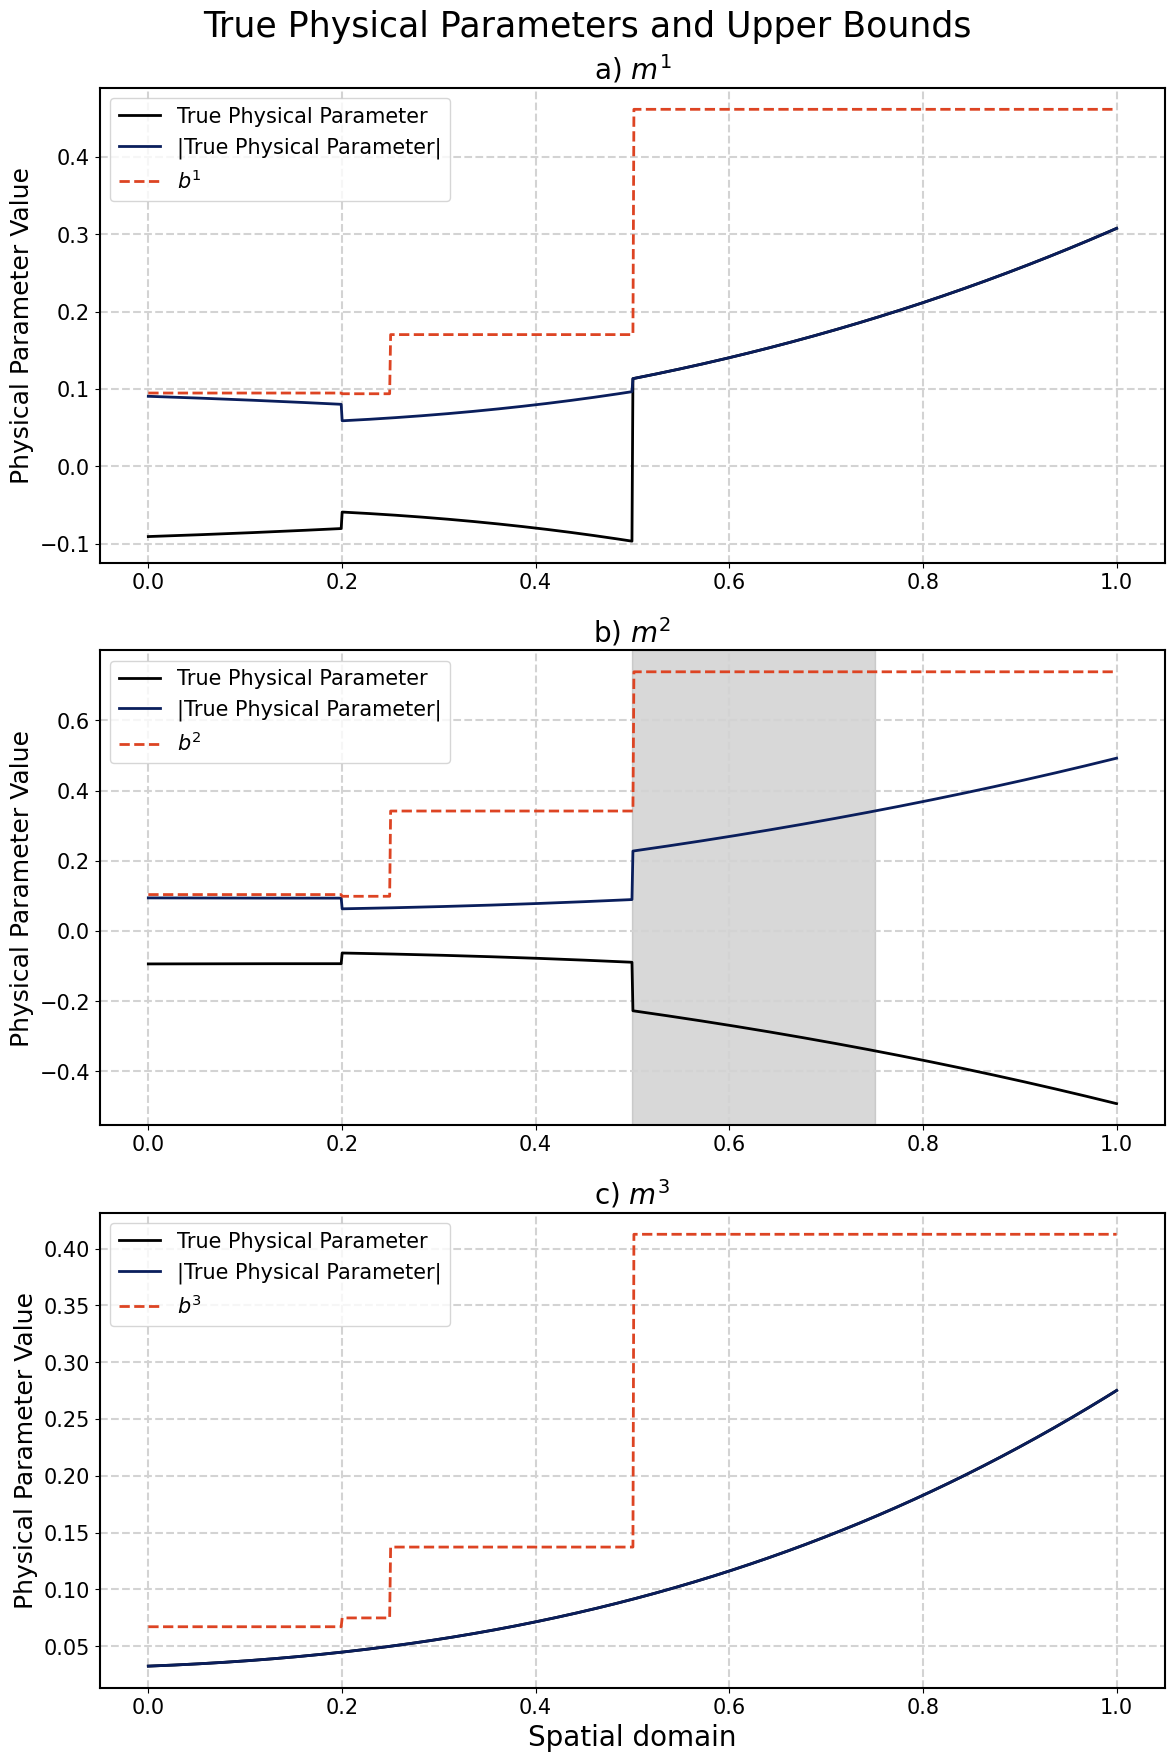

In [30]:
####################
# Compute norm bound
####################
# Edit region -------------
# Places where the true model will be evaluated
intervals = np.array([0,0.2, 0.25, 0.501, domain.bounds[0][1]])
# Edit region -------------

upper_bounds = []
for model in true_model:
    values = np.abs(model.evaluate(intervals[1:]))*1.5
    upper_bound = functions.Piecewise_1D(domain=model.domain,
                                         intervals=intervals,
                                         values=values)
    upper_bounds.append(upper_bound)

norm_bound = M.norm(tuple(upper_bounds))
bound_label = ['$b^1$', '$b^2$', '$b^3$']
fig, axes = plt.subplots(len(physical_parameters), 1, figsize=(12,6*len(physical_parameters)))

for i, (upperbound, submodel, physical_parameter) in enumerate(zip(upper_bounds, true_model, physical_parameters)):
    axes[i].plot(domain.mesh, submodel.evaluate(domain.mesh),
             label='True Physical Parameter', color='black', linewidth=2)
    axes[i].plot(domain.mesh, np.abs(submodel.evaluate(domain.mesh)),
             label='|True Physical Parameter|', color=colors[99], linewidth=2)
    axes[i].plot(domain.mesh, upperbound.evaluate(domain.mesh),
             label=bound_label[i], color='#dd4423', linestyle='--', linewidth=2)
    # Set title and labels
    axes[i].set_title(labels[i] + physical_parameters_symbols[physical_parameter], fontsize=20)
    axes[i].set_ylabel('Physical Parameter Value', fontsize=18)
    # Set tick parameters
    axes[i].tick_params(axis='both', which='major', labelsize=15)
    # Add legend
    axes[i].grid(True, linestyle='--', linewidth=1.5, color='lightgray')  # Add gridlines
    axes[i].legend(fontsize=15)
y_min, y_max = axes[1].get_ylim()
axes[1].fill_betweenx([y_min, y_max], 0.5, 0.75, color='gray', alpha=0.3, label='No Sensitivity Region')
axes[1].set_ylim([y_min, y_max])
plt.suptitle('True Physical Parameters and Upper Bounds', fontsize=25)
plt.xlabel('Spatial domain', fontsize=20)
plt.tight_layout()
plt.savefig('bound.pdf', bbox_inches='tight')
plt.show()

Now with all the components at hand, we put them all in a "Problem" class instance

In [31]:
problem = Problem(M=M, D=D, P=P, G=G, T=T, norm_bound=norm_bound, data=data)

And we solve the problem.

In [32]:
problem.solve()

With the problem solved, we will find the solution (property bounds) in "problem.solution" and we can plot it.

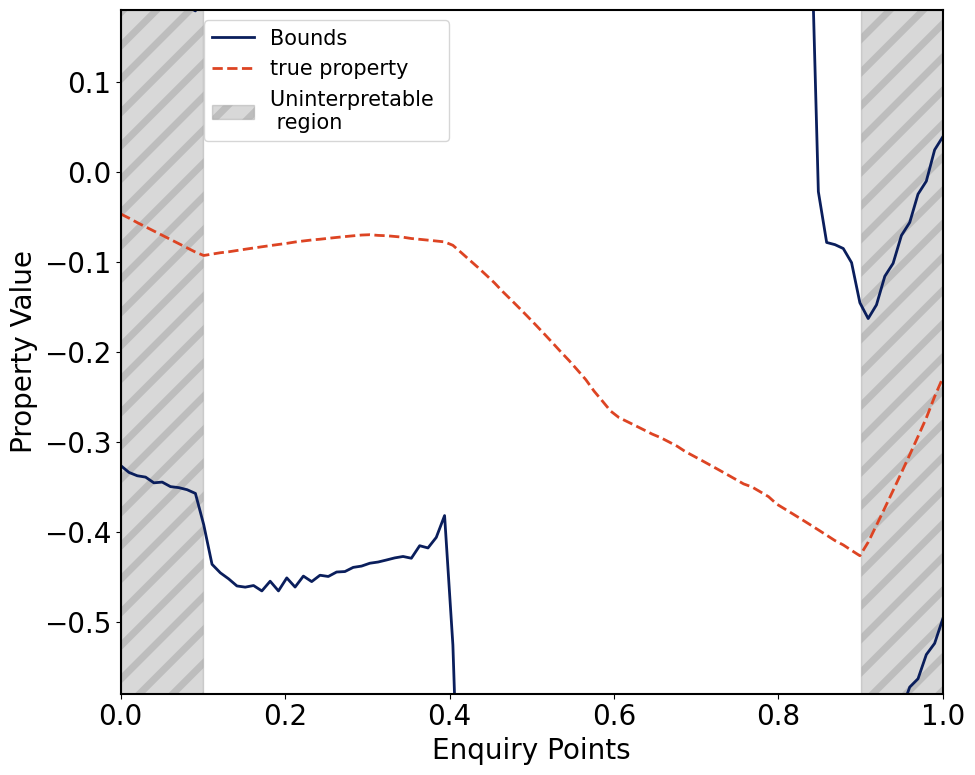

In [36]:
###############
# Plot solution
###############
# We compute the true property for plotting purposes only
true_property = T.map(true_model)
# Find limits for y axis
matplotlib.rcParams['hatch.linewidth'] = 5.0
y_max = np.mean(true_property) + (np.max(true_property) - np.min(true_property))
y_min = np.mean(true_property) - (np.max(true_property) - np.min(true_property))
# Plot the Solution section
plt.figure('Solution', figsize=(10, 8))
#plt.title('Property Bounds', fontsize=25, fontweight='bold')  # Increase font size and add bold
plt.plot(enquiry_points, problem.solution['upper bound'], color=colors[99],
         linewidth=2, label='Bounds')  # Increase line width
plt.plot(enquiry_points, problem.solution['lower bound'], color=colors[99],
         linewidth=2)  # Increase line width and use dashed line
plt.plot(enquiry_points, true_property, color='#dd4423', linestyle='--',
         linewidth=2, label='true property')
plt.fill_betweenx([y_min, y_max], 0, width/2, color='gray', hatch='/',
                  alpha=0.3, label='Uninterpretable \n region')
plt.fill_betweenx([y_min, y_max], domain.bounds[0][1] - width/2, domain.bounds[0][1],
                  color='gray', hatch='/', alpha=0.3)
plt.xlim([domain.bounds[0][0], domain.bounds[0][1]])
plt.ylim([y_min, y_max])
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(fontsize=15, loc='upper center', bbox_to_anchor=(0.25, 1))
plt.xlabel('Enquiry Points', fontsize=20)  # Add X-axis label with fontsize
plt.ylabel('Property Value', fontsize=20)  # Add Y-axis label with fontsize
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.savefig('solution_m2_' +  str(targets_dict['m_2'][0]) + '_' + str(width) +'.png', dpi=300, bbox_inches='tight')  # Increase resolution for high-quality output
plt.show()

We can also look at some resolving kernels 

In [37]:
problem._compute_resolving_kernels()

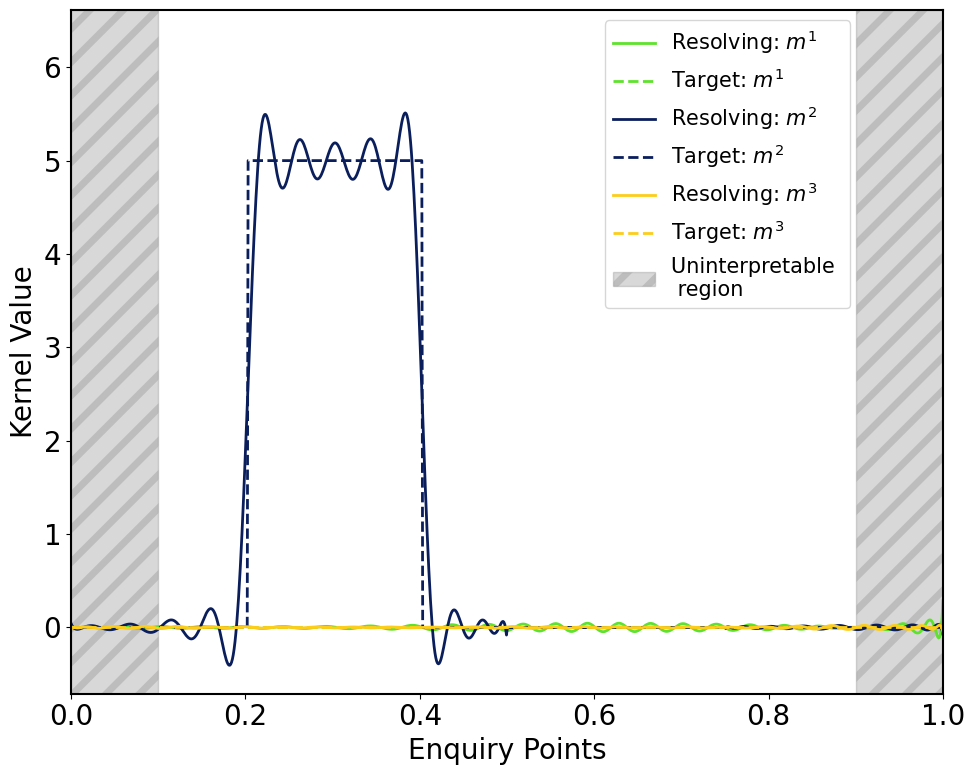

In [38]:
# Edit region -------------
which_kernel = 30
# Edit region -------------

param_color = dict(zip(physical_parameters, ['#5ee22d', colors[99] , '#fccd1a']))
plt.figure(1, figsize=(10,8))
# Lists to store the y-values of all plotted data
all_y_values = []

for param, mapping in zip(physical_parameters, problem.A.mappings):
    # Plot resolving kernel
    resolving_kernel_y_values = mapping.kernels[which_kernel].evaluate(domain.mesh)
    plt.plot(domain.mesh, resolving_kernel_y_values,
             color=param_color[param], linewidth=2,
             label='Resolving: ' + physical_parameters_symbols[param])
    all_y_values.extend(resolving_kernel_y_values)

    # Plot target kernel
    target_kernel_y_values = targets_dict[param][which_kernel].evaluate(domain.mesh)
    plt.plot(domain.mesh, target_kernel_y_values,
             linestyle='dashed', color=param_color[param], linewidth=2,
             label='Target: ' + physical_parameters_symbols[param])
    all_y_values.extend(target_kernel_y_values)

# Calculate the minimum and maximum y-values from all the plotted data
y_min = min(all_y_values)*1.2
y_max = max(all_y_values)*1.2
if y_min <= 0:
    y_min = -(y_max - y_min)*0.1

# Fill between the specified y_min and y_max values
plt.fill_betweenx([y_min, y_max], 0, width/2, color='gray', hatch='/', alpha=0.3, label='Uninterpretable \n region')
plt.fill_betweenx([y_min, y_max], domain.bounds[0][1] - width/2, domain.bounds[0][1], color='gray', hatch='/', alpha=0.3)
plt.xlim([domain.bounds[0][0], domain.bounds[0][1]])
plt.ylim([y_min, y_max])
#plt.title('Resolving Kernels vs Target Kernels', fontsize=25, fontweight='bold')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(fontsize=15, bbox_to_anchor=(0.6,1))
plt.xlabel('Enquiry Points', fontsize=20)
plt.ylabel('Kernel Value', fontsize=20)
plt.tight_layout()
plt.savefig('resolving_kernel_' + str(targets_dict['m_2'][0]) +'_' + str(which_kernel) + '.png', bbox_inches='tight', dpi=300)
plt.show()

And we can also compute the least norm solution

In [39]:
problem._compute_least_norm_solution()

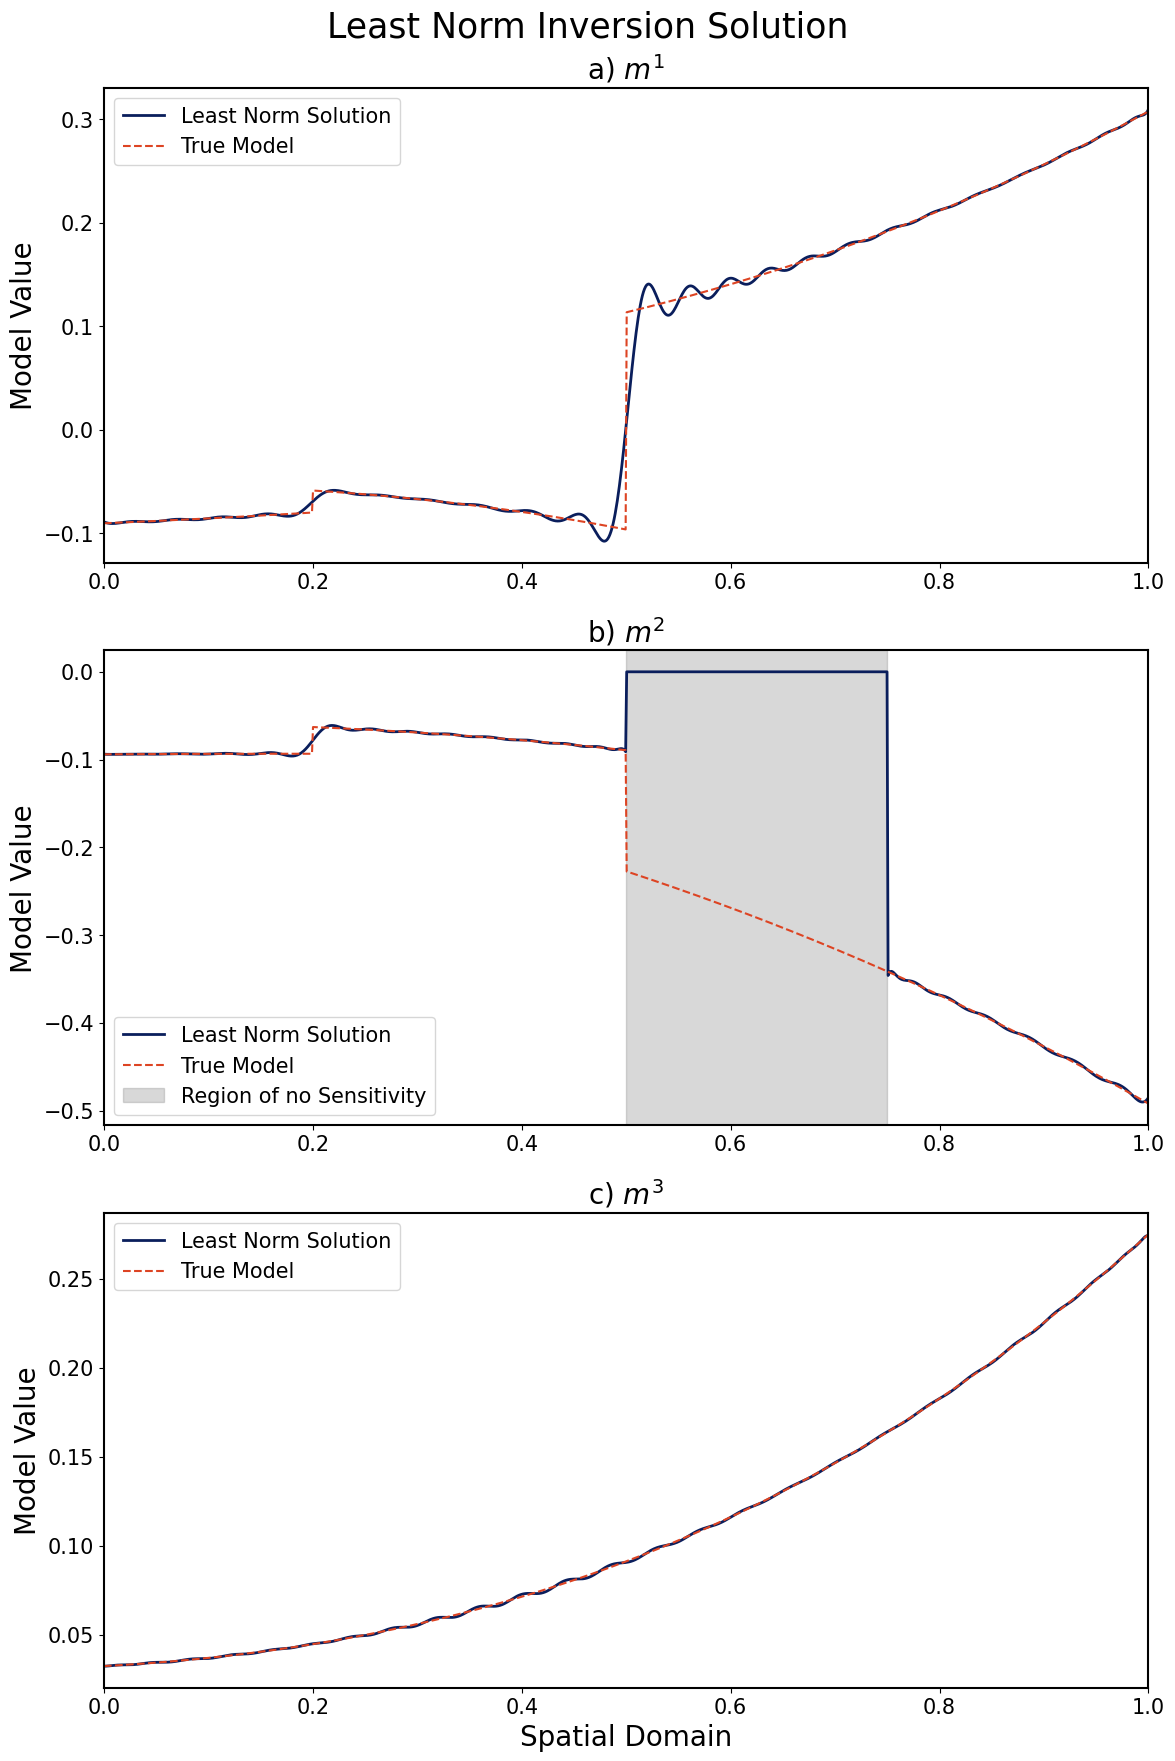

In [40]:
fig, axes = plt.subplots(len(physical_parameters), 1, figsize=(12, 6*len(physical_parameters)))
for i, physical_parameter in enumerate(physical_parameters):
    axes[i].set_title(labels[i] + physical_parameters_symbols[physical_parameter], fontsize=20)  # Increase font size and add bold
    axes[i].plot(domain.mesh, problem.least_norm_solution[i].evaluate(domain.mesh),
            color=colors[99], linewidth=2, label='Least Norm Solution')  # Increase line width
    axes[i].plot(domain.mesh, true_model[i].evaluate(domain.mesh),
                 color='#dd4423', linestyle='dashed', label='True Model')
    axes[i].set_ylabel('Model Value', fontsize=20)  # Add Y-axis label with fontsize
    y_min, y_max = axes[i].get_ylim()
    if physical_parameter == 'm_2':
        axes[i].fill_betweenx([y_min, y_max], 0.5, 0.75, color='gray', alpha=0.3, label='Region of no Sensitivity')
    axes[i].set_ylim([y_min, y_max])
    axes[i].set_xlim([domain.bounds[0][0], domain.bounds[0][1]])
    axes[i].legend(fontsize=15)
    axes[i].tick_params(axis='both', which='major', labelsize=15)
plt.suptitle('Least Norm Inversion Solution', fontsize=25)  # Increase font size and add bold
plt.xlabel('Spatial Domain', fontsize=20)  # Add X-axis label with fontsize
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.savefig('least_norm_solution_fake.png', dpi=300, bbox_inches='tight')  # Increase resolution for high-quality output
plt.show()

In [ ]:
print(problem.norm_bound)
print(M.norm(true_model))

1.1928313327171445
0.5465061243881661
